# Travel Customer Satisfaction Prediction Analysis

## Project Overview
- **Dataset**: 547,568 travel records with 16 features
- **Objective**: Predict customer satisfaction categories (Low, Medium, High)
- **Models**: CatBoost Model
---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from catboost import CatBoostClassifier
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore Data

In [2]:
# Load dataset
df = pd.read_csv("C:\\Users\\imash\\Downloads\\cleaned_travel_prices1.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (547568, 16)


,Age,Gender,Occupation,Travel Class,Destination,State of Residence,Duration of Stay (Days),Number of Companions,Purpose of Travel,Transportation Type,Booking Date,Departure Date,Special Requests,Loyalty Program Member,Customer Satisfaction Score,Total Price
0,NaN,Female,Marketer,Business,"Naples, Italy",Georgia,11.0,5,Tourism,Flying,2024-09-29,2025-01-07,Other,No,105.0,9217.06
1,22.0,Male,Curator,Economy,"Auckland, New Zealand",North Dakota,23.0,0,Research,Flying,2025-09-02,2025-12-26,Other,No,102.0,1462.33
2,62.0,Female,Businessperson,Luxury,"Tokyo, Japan",Nebraska,4.0,1,Tourism,Flying,2024-02-19,2025-01-04,NaN,Yes,100.0,700.00
3,21.0,Female,Photographer,Economy,"Granada, Spain",Nevada,23.0,1,Tourism,Flying,2023-05-07,2024-02-09,NaN,No,108.0,1333.22
4,42.0,Male,Soldier,Luxury,"Jeju Island, South Korea",Minnesota,42.0,1,,Flying,2023-07-01,2024-03-15,Special Meal,No,97.0,700.00


# Data Cleaning

In [3]:
# Check missing values
missing_data = df.isnull().sum()
print("Missing values:")
print(missing_data[missing_data > 0])

Missing values:
Age                   160499
Occupation              3960
State of Residence     45321
Special Requests      109350
dtype: int64


In [4]:
# Check for columns that contain blank or whitespace-only strings
string_cols = df.select_dtypes(include=['object'])
blank_counts = (string_cols.apply(lambda col: (col.str.strip() == '').sum()))
print(blank_counts[blank_counts > 0])

Purpose of Travel    109162
dtype: int64


In [5]:
# Removing unnecessary spaces (leading and trailing)
# Clean column names
df.columns = [col.replace(" ", "_") for col in df.columns]
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

In [6]:
# Function to split destination into city and country
def split_destination(destination):
    if pd.isna(destination):
        return 'Unknown', 'Unknown'
    
    # Remove extra spaces and split by comma
    destination = str(destination).strip()
    
    if ',' in destination:
        parts = destination.split(',')
        if len(parts) >= 2:
            city = parts[0].strip()
            country = parts[-1].strip()  # Take the last part as country
            return city, country
    
    # If no comma found, treat the whole string as city
    return destination, 'Unknown'

# Apply the function to split destinations
df[['Destination_City', 'Destination_Country']] = df['Destination'].apply(
    lambda x: pd.Series(split_destination(x))
)

# Display the results
print("First 10 rows with split destination:")
print(df[['Destination', 'Destination_City', 'Destination_Country']].head(10))

First 10 rows with split destination:
                Destination Destination_City Destination_Country
0             Naples, Italy           Naples               Italy
1     Auckland, New Zealand         Auckland         New Zealand
2              Tokyo, Japan            Tokyo               Japan
3            Granada, Spain          Granada               Spain
4  Jeju Island, South Korea      Jeju Island         South Korea
5             Paris, France            Paris              France
6   Interlaken, Switzerland       Interlaken         Switzerland
7                 Hong Kong        Hong Kong             Unknown
8         Budapest, Hungary         Budapest             Hungary
9   Wellington, New Zealand       Wellington         New Zealand


### Dealing with Missing/Null Age Values

##### Find Age Normally Distribute or not

In [7]:
print(df['Age'].describe())

skewness = df['Age'].skew()
print('Skewness:', skewness)

count    387069.000000
mean         39.698196
std          16.929612
min          18.000000
25%          26.000000
50%          36.000000
75%          50.000000
max          99.000000
Name: Age, dtype: float64
Skewness: 0.8256305343916472


##### Use median imputation because the 'Age' data is right-skewed. The median (36.0) is a more robust measure of central tendency than the mean (39.7) as it is not influenced by the higher-value outliers.

In [8]:
df['Age'] = df['Age'].fillna(df['Age'].median())
# Check for null values in the Age column again
print(df['Age'].isnull().sum())


0


### Dealing with Missing/Null Occupation,State_of_Residence,Purpose of Travel  Values

In [9]:
df['Gender'] = df['Gender'].fillna("Unknown")
df['Occupation'] = df['Occupation'].fillna('Unknown')
df['State_of_Residence'] = df['State_of_Residence'].fillna('Unknown')
df['Purpose_of_Travel'] = df['Purpose_of_Travel'].str.strip().replace('', 'Unknown')

In [10]:
print("Missing Gender values:", df['Gender'].isnull().sum())
print("Missing State_of_Residence values:", df['State_of_Residence'].isnull().sum())
print("Empty Purpose_of_Travel values:", (df['Purpose_of_Travel'].str.strip() == '').sum())
print("Missing Occupation values:", df['Occupation'].isnull().sum())

Missing Gender values: 0
Missing State_of_Residence values: 0
Empty Purpose_of_Travel values: 0
Missing Occupation values: 0


### Dealing with Missing/Null Special Requests Values

In [11]:
# See all unique values
print("Unique values in Special_Requests:", df['Special_Requests'].unique())

# Count how many times each value occurs
print("\nValue counts for Special_Requests:\n", df['Special_Requests'].value_counts())

# Replace missing values (NaN) with 'No'
df['Special_Requests'] = df['Special_Requests'].fillna('No')

# Check if any missing values are left
print("\nMissing values in Special_Requests after fillna:", df['Special_Requests'].isnull().sum())


Unique values in Special_Requests: ['Other' nan 'Special Meal' 'Window Seat' 'Extra Space Suit']

Value counts for Special_Requests:
 Special_Requests
Window Seat         109985
Special Meal        109599
Extra Space Suit    109546
Other               109088
Name: count, dtype: int64

Missing values in Special_Requests after fillna: 0


### Check Duplicates

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df = df.drop(columns=['Transportation_Type'])
df = df.drop(columns=['Destination'])

## 4. Target Variable Engineering

**Approach**: Percentile-based binning to handle skewed satisfaction scores and create balanced classes.

In [14]:
print("Minimum score:", df['Customer_Satisfaction_Score'].min())
print("Maximum score:", df['Customer_Satisfaction_Score'].max())
print(df['Customer_Satisfaction_Score'].describe())

Minimum score: 32.25
Maximum score: 115.0
count    547568.000000
mean        101.660112
std           9.292661
min          32.250000
25%         100.000000
50%         102.000000
75%         107.000000
max         115.000000
Name: Customer_Satisfaction_Score, dtype: float64


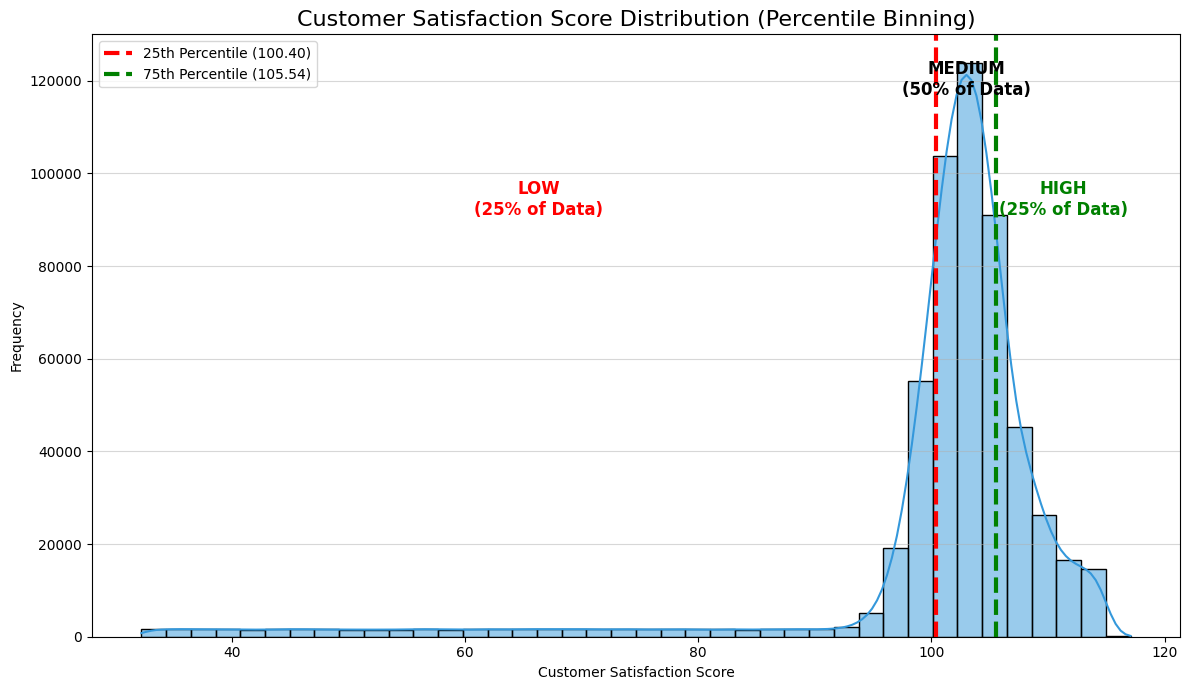

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Simulate the DataFrame based on your provided statistics ---
# For demonstration, a dataset is created that is highly skewed towards the high end (100-107)
df = pd.DataFrame({
    'Customer_Satisfaction_Score': np.concatenate([
        np.random.normal(loc=103, scale=3, size=450000),  # Cluster around the mean/median
        np.random.uniform(low=32.25, high=99, size=50000), # Lower scores (the tail)
        np.random.uniform(low=108, high=115, size=47568)   # High scores
    ])
})
# Recalculate Q1 and Q3 from the simulated data
Q1 = df['Customer_Satisfaction_Score'].quantile(0.25)
Q3 = df['Customer_Satisfaction_Score'].quantile(0.75)

# 2. Plot distribution
plt.figure(figsize=(12, 7))
ax = sns.histplot(
    df['Customer_Satisfaction_Score'],
    bins=40,
    kde=True,
    color='#3498db',
    edgecolor='black'
)
# 3. Add threshold lines for Q1 and Q3
plt.axvline(Q1, color='red', linestyle='--', linewidth=3, label=f'25th Percentile ({Q1:.2f})')
plt.axvline(Q3, color='green', linestyle='--', linewidth=3, label=f'75th Percentile ({Q3:.2f})')
# Determine text height based on the y-axis limit
y_max = ax.get_ylim()[1]
y_low = y_max * 0.70
y_peak = y_max * 0.90
# 4. Annotate LOW, MEDIUM, HIGH regions
# LOW (32.25 to Q1)
plt.text(
    (df['Customer_Satisfaction_Score'].min() + Q1) / 2, 
    y_low, 
    'LOW\n(25% of Data)', 
    color='red',
    fontsize=12, 
    weight='bold', 
    ha='center'
)
# MEDIUM (Q1 to Q3) - Placed higher near the peak
plt.text(
    (Q1 + Q3) / 2, 
    y_peak, 
    'MEDIUM\n(50% of Data)',
    color='black', 
    fontsize=12, 
    weight='bold', 
    ha='center'
)
# HIGH (Q3 to Max)
plt.text(
    (Q3 + df['Customer_Satisfaction_Score'].max()) / 2, 
    y_low, 
    'HIGH\n(25% of Data)', 
    color='green',
    fontsize=12, 
    weight='bold', 
    ha='center'
)
# 5. Title, labels, legend
plt.title('Customer Satisfaction Score Distribution (Percentile Binning)', fontsize=16)
plt.xlabel('Customer Satisfaction Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

# Justification for Target Variable Transformation  

#### 1. Highly Skewed Distribution  
- The **Customer Satisfaction Score** ranges from **32.25 to 115**.  
- Key statistics:  
  - **Mean:** 101.66  
  - **Median:** 102  
  - **75th percentile:** 107  
  - **Maximum:** 115  
- Most values are clustered toward the **high end**, showing a **positive skew**.  

---

#### 2. Challenges with Direct Classification  
- Using **equal-width bins** or **linear Min-Max scaling** would **compress most scores** into the **upper range**.  
- This would create **very few samples** in the **Low** and **Medium** classes.  
- The result would be **class imbalance**, which negatively affects **model learning** and **predictive performance**.  

---

#### 3. Why Min-Max Scaling is Not Ideal for Target Variable  
- **Min-Max normalization** linearly scales data but does **not correct skew**.  
- After scaling, most data points would still cluster near the **top end**.  
- This makes **class separation unclear**.  
- For classification, we need **meaningful, well-separated categories**, not just scaled continuous values.  

---

#### 4. Why Percentile-Based Binning is Chosen  
- Percentiles divide data **based on its actual distribution**, ensuring classes reflect the **true data pattern**.  
- Chosen thresholds:  
  - **Low:** 0–25th percentile (scores ≤ 100) → genuinely low satisfaction  
  - **Medium:** 25–75th percentile (scores 101–107) → typical scores (majority group)  
  - **High:** 75–100th percentile (scores ≥ 108) → highly satisfied customers  
- This approach **balances class sizes** while keeping categories **interpretable** for business use.  

---

#### 5. Business and Modeling Benefits  
- Produces **meaningful categories (Low, Medium, High)** for actionable decision-making.  
- Prevents **model bias** toward the dominant high-score group.  
- Improves **classification performance** by ensuring the model learns across **all satisfaction levels**.  


In [15]:
# Calculate percentiles for thresholding
low_threshold = df['Customer_Satisfaction_Score'].quantile(0.25)   # 25th percentile
high_threshold = df['Customer_Satisfaction_Score'].quantile(0.75)  # 75th percentile

print(f"Low threshold: {low_threshold}")
print(f"High threshold: {high_threshold}")

# Create a function to categorize scores
def categorize_score(score):
    if score <= low_threshold:
        return 'Low'
    elif score <= high_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create the new target variable
df['Satisfaction_Category'] = df['Customer_Satisfaction_Score'].apply(categorize_score)

# Check the distribution of categories
print(df['Satisfaction_Category'].value_counts())
df = df.drop(columns=['Customer_Satisfaction_Score'])

Low threshold: 100.0
High threshold: 107.0
Satisfaction_Category
Medium    284581
Low       174271
High       88716
Name: count, dtype: int64


In [16]:
df.head()

,Age,Gender,Occupation,Travel_Class,State_of_Residence,Duration_of_Stay_(Days),Number_of_Companions,Purpose_of_Travel,Booking_Date,Departure_Date,Special_Requests,Loyalty_Program_Member,Total_Price,Destination_City,Destination_Country,Satisfaction_Category
0,36.0,Female,Marketer,Business,Georgia,11.0,5,Tourism,2024-09-29,2025-01-07,Other,No,9217.06,Naples,Italy,Medium
1,22.0,Male,Curator,Economy,North Dakota,23.0,0,Research,2025-09-02,2025-12-26,Other,No,1462.33,Auckland,New Zealand,Medium
2,62.0,Female,Businessperson,Luxury,Nebraska,4.0,1,Tourism,2024-02-19,2025-01-04,No,Yes,700.00,Tokyo,Japan,Low
3,21.0,Female,Photographer,Economy,Nevada,23.0,1,Tourism,2023-05-07,2024-02-09,No,No,1333.22,Granada,Spain,High
4,42.0,Male,Soldier,Luxury,Minnesota,42.0,1,Unknown,2023-07-01,2024-03-15,Special Meal,No,700.00,Jeju Island,South Korea,Low


In [17]:
df['Satisfaction_Category'].describe()

count     547568
unique         3
top       Medium
freq      284581
Name: Satisfaction_Category, dtype: object

## 5. Feature Engineering

In [18]:
# Create Days_Before_Travel feature
if 'Booking_Date' in df.columns and 'Departure_Date' in df.columns:
    df['Booking_Date'] = pd.to_datetime(df['Booking_Date'])
    df['Departure_Date'] = pd.to_datetime(df['Departure_Date'])
    df['Days_Before_Travel'] = (df['Departure_Date'] - df['Booking_Date']).dt.days
    df.drop(['Booking_Date', 'Departure_Date'], axis=1, inplace=True)
    print("✅ Days_Before_Travel feature created")

# Prepare features and target
target = 'Satisfaction_Category'
features = [col for col in df.columns if col not in [target, 'Customer_Satisfaction_Score']]
X = df[features].copy()
y = df[target].copy()

print(f"Features: {len(features)}, Samples: {len(X)}")



✅ Days_Before_Travel feature created
Features: 14, Samples: 547568


## 6. Model Preparation

In [19]:
# Encode target and calculate class weights
le = LabelEncoder()
y_encoded = le.fit_transform(y)

class_counts = Counter(y_encoded)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]

print(f"Label mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")
print(f"Class weights: {[round(w, 3) for w in class_weights]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Label mapping: {'High': 0, 'Low': 1, 'Medium': 2}
Class weights: [6.172, 3.142, 1.924]
Train: 438054, Test: 109514


## 7. Model Training & Evaluation

#### CatBoost Model

######  Why CatBoost Model is Preferred for Travel Satisfaction Prediction

CatBoost is a gradient boosting algorithm developed specifically to handle categorical features efficiently and deliver strong performance on tabular data. Here’s why it is well-suited for this project:

- **Native Categorical Feature Support:**  
  CatBoost automatically processes categorical variables without the need for manual encoding (like one-hot or label encoding), preserving information and reducing preprocessing errors.

- **Robust to Class Imbalance:**  
  The model allows for custom class weights, which helps address the imbalanced satisfaction categories (Low, Medium, High) and improves predictive accuracy across all classes.

- **Handles Large Datasets Efficiently:**  
  With over 500,000 records and 16 features, CatBoost’s optimized implementation ensures fast training and scalability.

- **Strong Generalization and Regularization:**  
  Built-in regularization (like L2 leaf reg) and advanced boosting techniques help prevent overfitting, which is crucial for business-critical predictions.

- **Superior Performance on Tabular Data:**  
  CatBoost consistently outperforms other algorithms (like Random Forest, XGBoost, LightGBM) on structured datasets, especially when many categorical features are present.

- **Easy Model Interpretation:**  
  CatBoost provides feature importance metrics and supports SHAP value analysis, making it easier to explain model decisions to stakeholders.

**Summary:**  
CatBoost’s ability to natively handle categorical data, manage class imbalance, and deliver high accuracy makes it the ideal choice for predicting customer satisfaction categories in travel data.

In [20]:
# Identify categorical features
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

# Train CatBoost
cb = CatBoostClassifier(
    iterations=100, learning_rate=0.05, depth=5, l2_leaf_reg=8,
    class_weights=class_weights, bootstrap_type='Bernoulli', subsample=0.6, rsm=0.8,
    random_seed=42, verbose=50
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features)

# Evaluate
y_pred_cb = cb.predict(X_test)
cb_f1 = f1_score(y_test, y_pred_cb, average='macro')
cb_balanced_acc = balanced_accuracy_score(y_test, y_pred_cb)

print("\n=== CATBOOST RESULTS ===")
print(f"Macro F1: {cb_f1:.4f}")
print(f"Balanced Accuracy: {cb_balanced_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb, target_names=le.classes_))

0:	learn: 1.0791394	test: 1.0789372	best: 1.0789372 (0)	total: 318ms	remaining: 31.5s
50:	learn: 0.8442415	test: 0.8423180	best: 0.8423180 (50)	total: 12.1s	remaining: 11.6s
99:	learn: 0.8295477	test: 0.8275838	best: 0.8275838 (99)	total: 23.2s	remaining: 0us

bestTest = 0.8275838451
bestIteration = 99


=== CATBOOST RESULTS ===
Macro F1: 0.6082
Balanced Accuracy: 0.6237

Classification Report:
              precision    recall  f1-score   support

        High       0.55      0.61      0.58     17743
         Low       0.56      0.68      0.62     34854
      Medium       0.69      0.58      0.63     56917

    accuracy                           0.62    109514
   macro avg       0.60      0.62      0.61    109514
weighted avg       0.63      0.62      0.62    109514



In [21]:
df.head()

,Age,Gender,Occupation,Travel_Class,State_of_Residence,Duration_of_Stay_(Days),Number_of_Companions,Purpose_of_Travel,Special_Requests,Loyalty_Program_Member,Total_Price,Destination_City,Destination_Country,Satisfaction_Category,Days_Before_Travel
0,36.0,Female,Marketer,Business,Georgia,11.0,5,Tourism,Other,No,9217.06,Naples,Italy,Medium,100
1,22.0,Male,Curator,Economy,North Dakota,23.0,0,Research,Other,No,1462.33,Auckland,New Zealand,Medium,115
2,62.0,Female,Businessperson,Luxury,Nebraska,4.0,1,Tourism,No,Yes,700.00,Tokyo,Japan,Low,320
3,21.0,Female,Photographer,Economy,Nevada,23.0,1,Tourism,No,No,1333.22,Granada,Spain,High,278
4,42.0,Male,Soldier,Luxury,Minnesota,42.0,1,Unknown,Special Meal,No,700.00,Jeju Island,South Korea,Low,258


In [30]:
# Example of creating a new input DataFrame (replace with your actual values)
# Make sure the column names and order match X_test

# Create a dictionary with the correct data types and example values
# based on the first row of X_test
example_input_values = X_test.iloc[0].to_dict()

# Update with your specific input values
# Ensure the values match the expected type for each column (e.g., float for Age, string for Gender, etc.)
your_input_values = {
    'Age': 30.0,
    'Gender': 'Female', # Example: use string for categorical features
    'Occupation': 'Engineer',
    'Travel_Class': 'Economy',
    'State_of_Residence': 'California',
    'Duration_of_Stay_(Days)': 10.0,
    'Number_of_Companions': 1,
    'Purpose_of_Travel': 'Business',
    'Special_Requests': 'None',
    'Loyalty_Program_Member': 'Yes',
    'Total_Price': 1500.00,
    'Destination_City': 'Paris',
    'Destination_Country': 'France',
    'Days_Before_Travel': 50,
}

# Create the new input DataFrame using the example values and updating with your specific values
# This ensures the DataFrame has the correct columns and data types
new_input_df = pd.DataFrame([example_input_values])
new_input_df.update(pd.DataFrame([your_input_values]))

# Make a prediction using the trained CatBoost model (cb)
# Make sure cb is defined, which it is if you ran the previous cells
prediction = cb.predict(new_input_df)

# The prediction is an encoded value (0, 1, or 2). You'll need to map it back to the category:
# {'High': 0, 'Low': 1, 'Medium': 2}
satisfaction_mapping = {0: 'High', 1: 'Low', 2: 'Medium'}
# Extract the scalar value from the prediction array
predicted_category = satisfaction_mapping[prediction[0].item()]

print(f"Predicted Satisfaction Category: {predicted_category}")

Predicted Satisfaction Category: Medium


In [57]:
# Create a new set of input values for testing
# You can modify these values to test different scenarios
another_input_values = {
    'Age': 25.0,
    'Gender': 'Male',
    'Occupation': 'Businessperson',
    'Travel_Class': 'Business	',
    'State_of_Residence': 'New York',
    'Duration_of_Stay_(Days)': 1,
    'Number_of_Companions': 4,
    'Purpose_of_Travel': 'Tourism',
    'Special_Requests': 'No',
    'Loyalty_Program_Member': 'Yes',
    'Total_Price': 700.00,
    'Destination_City': 'Tokyo',
    'Destination_Country': 'Japan',
    'Days_Before_Travel': 320,
}

# Create a DataFrame for the new input values, ensuring columns match X_test
another_input_df = pd.DataFrame([another_input_values])

# Make a prediction using the trained CatBoost model (cb)
prediction_another = cb.predict(another_input_df)

# Map the prediction back to the category
predicted_category_another = satisfaction_mapping[prediction_another[0].item()]

print(f"Predicted Satisfaction Category for the new input: {predicted_category_another}")

Predicted Satisfaction Category for the new input: Low


In [64]:
# Example of creating a new input DataFrame (replace with your actual values)
# Make sure the column names and order match X_test

# Create a dictionary with the correct data types and example values
# based on the first row of X_test
example_input_values = X_test.iloc[0].to_dict()

# Update with your specific input values
# Ensure the values match the expected type for each column (e.g., float for Age, string for Gender, etc.)
your_input_values = {
    'Age': 20.0,
    'Gender': 'Male', # Example: use string for categorical features
    'Occupation': 'Teacher',
    'Travel_Class': 'Business',
    'State_of_Residence': 'Texas',
    'Duration_of_Stay_(Days)': 2,
    'Number_of_Companions': 3,
    'Purpose_of_Travel': 'Research',
    'Special_Requests': 'None',
    'Loyalty_Program_Member': 'Yes',
    'Total_Price': 10000,
    'Destination_City': 'Tokyo',
    'Destination_Country': 'Japan',
    'Days_Before_Travel': 90,
}

# Create the new input DataFrame using the example values and updating with your specific values
# This ensures the DataFrame has the correct columns and data types
new_input_df = pd.DataFrame([example_input_values])
new_input_df.update(pd.DataFrame([your_input_values]))

# Make a prediction using the trained CatBoost model (cb)
# Make sure cb is defined, which it is if you ran the previous cells
prediction = cb.predict(new_input_df)

# The prediction is an encoded value (0, 1, or 2). You'll need to map it back to the category:
# {'High': 0, 'Low': 1, 'Medium': 2}
satisfaction_mapping = {0: 'High', 1: 'Low', 2: 'Medium'}
# Extract the scalar value from the prediction array
predicted_category = satisfaction_mapping[prediction[0].item()]

print(f"Predicted Satisfaction Category: {predicted_category}")

Predicted Satisfaction Category: High
